讀取資料
看前五筆資料

In [1]:
import pandas as pd

df = pd.read_csv('./movie_data.csv', encoding='utf-8')
df.head(5)


,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


查看資料筆數和欄位數

In [2]:
print(df.shape)
print(df['sentiment'].value_counts())


(50000, 2)
1    25000
0    25000
Name: sentiment, dtype: int64


pre-processing
1. to lowercase
2. remove url and html tag
3. remove puctuation

In [3]:
from bs4 import BeautifulSoup
import re
import nltk

# to lowercase
df['review'] = df['review'].str.lower()

# remove url and html tag
df['review'] = df['review'].apply(lambda x: BeautifulSoup(x).get_text())
df['review'] = df['review'].apply(lambda x: re.sub(r"http\S+", "", x))

df.head(5)

,review,sentiment
0,"in 1974, the teenager martha moxley (maggie gr...",1
1,ok... so... i really like kris kristofferson a...,0
2,"***spoiler*** do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"i recently bought the dvd, forgetting just how...",0


In [4]:
# remove puctuation
df['review'] = df['review'].apply(lambda x: " ".join([re.sub('[^A-Za-z]+', '', x) for x in str(x).split()]))
df.head(10)

,review,sentiment
0,in the teenager martha moxley maggie grace mo...,1
1,ok so i really like kris kristofferson and his...,0
2,spoiler do not read this if you think about wa...,0
3,hi for all the people who have seen this wonde...,1
4,i recently bought the dvd forgetting just how ...,0
5,leave it to braik to put on a good show finall...,1
6,nathan detroit frank sinatra is the manager of...,1
7,to understand crash course in the right contex...,1
8,ive been impressed with chavezs stance against...,1
9,this movie is directed by renny harlin the fin...,1


切分資料集 train, val, test，其中train:test=7:3

In [5]:
# from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], train_size=0.7, test_size=0.3)
# # x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.7, test_size=0.3)
# print(x_train.head(5))
# print(x_test.head(5))
# print(y_train.head(5))
# print(y_test.head(5))

# dict = {'review':x_test, 'sentiment':y_test}
# df = pd.DataFrame(dict)
# df.to_csv('imdb_test.csv', header=True, index=False)

# # dict = {'review':x_val, 'sentiment':y_val}
# # df = pd.DataFrame(dict)
# # df.to_csv('imdb_val.csv', header=True, index=False)

# dict = {'review':x_train, 'sentiment':y_train}
# df = pd.DataFrame(dict)
# df.to_csv('imdb_train.csv', header=True, index=False)

In [6]:
test = pd.read_csv('imdb_test.csv', encoding='utf-8')
print(test.shape)
print(test['sentiment'].value_counts())

train = pd.read_csv('imdb_train.csv', encoding='utf-8')
print(train.shape)
print(train['sentiment'].value_counts())

# val = pd.read_csv('imdb_val.csv', encoding='utf-8')
# print(val.shape)
# print(val['sentiment'].value_counts())

(15000, 2)
0    7508
1    7492
Name: sentiment, dtype: int64
(35000, 2)
1    17508
0    17492
Name: sentiment, dtype: int64


使用tf-idf當作特徵

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer()
train_review = tfidf_vec.fit_transform(train['review'])
# val_review = tfidf_vec.fit_transform(val['review'])
test_review = tfidf_vec.transform(test['review'])

使用 word2vec當作評論特徵

logistic regression with keras

In [35]:
from calendar import EPOCH
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

number_of_classes = 1
number_of_features = train_review.shape[1]
model = Sequential()
model.add(Dense(number_of_classes, input_dim = number_of_features, activation = 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

train_sentiment = np.array(train['sentiment'])
history = model.fit(train_review.toarray(), train_sentiment, epochs= 20, batch_size=32, validation_split=0.2)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1)                 171612    
Total params: 171,612
Trainable params: 171,612
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
875/875 [==============================] - 67s 77ms/step - loss: 0.6383 - accuracy: 0.8260 - val_loss: 0.5883 - val_accuracy: 0.8584
Epoch 2/20
875/875 [==============================] - 27s 31ms/step - loss: 0.5408 - accuracy: 0.8795 - val_loss: 0.5172 - val_accuracy: 0.8683
Epoch 3/20
875/875 [==============================] - 16s 18ms/step - loss: 0.4705 - accuracy: 0.8960 - val_loss: 0.4664 - val_accuracy: 0.8726
Epoch 4/20
875/875 [==============================] - 8s 9ms/step - loss: 0.4177 - accuracy: 0.9081 - val_loss: 0.4283 - val_accuracy: 0.8786
Epoch 5/20
875/875 [==============================] - 8s 9ms/s

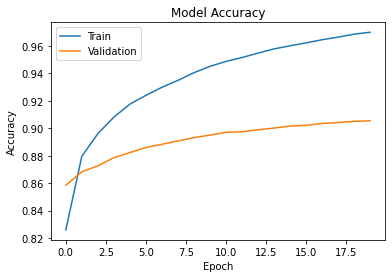

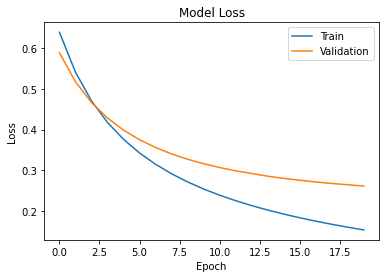

In [36]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy scores
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Model Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot training and validation loss scores
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend(loc='upper right')
plt.show()

In [37]:
test_sentiment = np.array(test['sentiment'])
test_loss, test_acc = model.evaluate(test_review.toarray(), test_sentiment)
print("test loss: ", test_loss)
print("test acc: ", test_acc)

469/469 [==============================] - 5s 11ms/step - loss: 0.2672 - accuracy: 0.8993
test loss:  0.26717445254325867
test acc:  0.8992666602134705
